# Assignment 1: Keeping Up With Social Information (Part 1)
## © Cristian Danescu-Niculescu-Mizil 2018
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday February 7th

This assignment is **individual**.

In this assignment we are practicing with post-processing on a conversational dataset taken from the reality TV show "Keeping Up With The Kardashians" and gathering some basic statistics about it. 

In the next assignment (Assignment 2) we will extend these tools to analyze conversational behavior.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* word tokenization
* histogram plotting using `matplotlib`
* character analysis via conversational language

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented to ensure that your logic is correct.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

You are expected to submit this .ipynb as your submission for Assignment 1. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

In [1]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

## Preliminary Data Cleansing
**Note: The following content is for you to review to understand how we cleaned and prepared the data for the analysis below.**

We will be continuing where we left off from Assignment 0. 

### Removing duplicates
If you are to examine the original transcripts you will see that many of them are near-duplicates, but most are not *perfect* duplicates. This is problematic, because we cannot simply remove identical transcripts.  Furthermore, we cannot just throw away documents that have large overlap, because we would be throwing away the valuable data that is *not* overlapping.

We therefore have to treat the transcripts as sequences, rather than as entire documents, and just remove subsequences that overlap.

We therefore used a standard python `difflib` package to write the `find_overlaps` function:

```python
import difflib
def find_overlaps(transcript_a, transcript_b, threshold=5):
    """Find and return the indices of overlapping subsequences between the two transcripts.
    Only return overlapping sequences that consist of at least `threshold` entries."""
    
    # We consider that two transcripts overlap when the messages
    # and the speakers are the same, but not the timestamp.
    
    # Massage the transcripts to disregard timestamp information.
    # note that a tuple is hashable, so is okay to use for difflib's SequenceMatcher class.
    msgs_a = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_a]
    msgs_b = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_b]
    matcher = difflib.SequenceMatcher(None, msgs_a, msgs_b)
    return list(filter(lambda tup: tup[2] >= threshold, matcher.get_matching_blocks()))
```

We now use the function above to remove duplicate subsequences. At each step, assume we have a list of "good" transcripts that have already been processed. When considering a new transcript, we first remove all subsequences that overlap with any of the already processed ones. Then, we split up the chunks that are not removed, and consider each of them a new transcript.

```python
deduped_transcripts = []
all_keys = sorted(transcripts.keys())

for key in all_keys:
    transcript = transcripts[key]
    for _, good_transcript in deduped_transcripts:
        overlaps = find_overlaps(transcript, good_transcript)
        for idx_a, _, size in overlaps:
            transcript[idx_a:idx_a + size] = [None] * size
    
    for is_not_none, group in groupby(transcript, lambda x: x is not None):
        if is_not_none:
            subtranscript = list(group)
            deduped_transcripts.append((key, subtranscript))
```

The `deduped_transcripts` are what you are now analyzing for the rest of the assignment. 

In [3]:
## We are loading the pickle file that contains all the deduped transcripts from Assignment 0
with open('deduped_transcripts.pickle','rb') as f:
    deduped_transcripts = pickle.load(f)
## We are also loading a pickle file of the titles file that we determined in the beginning of Assignment 0
with open('titles.pickle','rb') as f:
    titles = pickle.load(f)

# Language analysis

## Identifying the words
It's time to get down to the bread-and-butter of language analysis: the words used.  For simplification, **we consider a word to be a sequence of alphabetical characters. Treat all other characters as delimiters and do not return them.**


## Question 1 (Code Completion): Tokenization 

In the cell below: *Write a function to 'tokenize' a string into the constituent words*. 

You **must** use regex to satisfy the function specification. We recommend you leverage `re.findall`. 

Hint: Check out this online regex calculator: [here](https://regex101.com/)

In [4]:
def tokenize(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: Array
    """
    # YOUR CODE HERE
    return [x.lower() for x in re.findall(r"([A-Za-z]+)", text)]
    raise NotImplementedError()

In [5]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert tokenize("It's time to get down to the bread-and-butter") == \
    ['it', 's', 'time', 'to', 'get', 'down', 'to', 'the', 'bread', 'and', 'butter']
assert tokenize("Life, Liberty, & the Pursuit of Happiness") == \
    ['life', 'liberty', 'the', 'pursuit', 'of', 'happiness']

## Question 2 (Code Completion): Tokenization of Entire Transcript

In the cell below complete the function: *Leveraging the tokenize method to tokenize an entire transcript*. 

In [6]:
def tokenize_transcript(tokenize_method,input_transcript):
    """Returns a list of words contained in an entire transcript.
    Params: {tokenize_method: Function (a -> b),
             input_transcript: Tuple}
    Returns: Array
    """
    # YOUR CODE HERE
    words = []
    for lines in input_transcript[1]:
        words.extend(tokenize_method(lines["text"]))
    return words
    raise NotImplementedError()

In [7]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert len(tokenize_transcript(tokenize,deduped_transcripts[0])) > 6000 and \
    len(tokenize_transcript(tokenize,deduped_transcripts[0])) < 7000

## Question 3 (Code Completion) Number of Tokens
In the cell below write a function to *count how many tokens are used in the deduplicated transcripts in total*

In [8]:
def num_dedup_tokens(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             tokenize_transcript_method: Function (a -> b,c),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    # YOUR CODE HERE
    cnt = 0
    for transcript in input_transcripts:
        cnt += len(tokenize_transcript_method(tokenize_method, transcript))
    return cnt
    raise NotImplementedError()

In [9]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) > 200000 and \
    num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) < 300000

## Question 4 (Code Completion) Number of Distinct Words

In the cell below write a function to *count how many distinct words are in the deduplicated transcripts in total*. 

Hint: Use a *set*

In [10]:
def num_distinct_words(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of distinct tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             tokenize_transcript_method: Function (a -> b,c),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    # YOUR CODE HERE
    uni_words = set()
    for transcript in input_transcripts:
        uni_words.update(tokenize_transcript_method(tokenize_method, transcript))
    return len(uni_words)
    raise NotImplementedError()

In [11]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) > 8000 and \
    num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) < 9000

## Question 5 (Code Completion) Word Episode Counts

This question is asking you to build a dictionary `word_episode_count[word]` = *number of episodes in which it appears*. 

*Note: Keep in mind that the de-duplicated transcripts don't have unique titles!*

In the cell below write a function that: *for each distinct (unique) word, in how many different episodes does it appear?* 

In [12]:
def build_word_episode_count(tokenize_method,tokenize_transcript_method,input_transcripts,input_titles):
    """Returns a dictionary with the number of episodes each distinct word appears
        Params: {tokenize_method: Function (a -> b),
                 tokenize_transcript_method: Function (a -> b,c),
                 input_transcripts: Tuple List,
                 input_titles: Dictionary}
        Returns: Dict
    """
    # YOUR CODE HERE
    
    # BUILD UNIQUE WORD LIST
    uni_words = set()
    for transcript in input_transcripts:
        uni_words.update(tokenize_transcript_method(tokenize_method, transcript))
    
    # BUILD TOKENIZED TRANSCRIPTS DICTIONARY
    dict_tokenized_transcripts = []
    for transcript in input_transcripts:
            dict_tokenized_transcripts.append \
            ((transcript[0],tokenize_transcript_method(tokenize_method, transcript)))
    
    # BUILD WORD EPISODE COUNT DICTIONARY
    word_episode_count = dict()
    for word in uni_words:
        appear = set()
        for title_num, list_word in dict_tokenized_transcripts:
            if word in list_word:
                appear.add(input_titles[title_num])
        word_episode_count[word] = len(appear)
        
    return word_episode_count
    
    raise NotImplementedError()

In [13]:
word_episode_count = build_word_episode_count(tokenize,tokenize_transcript,deduped_transcripts,titles)   

In [14]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_word_episode_count returns the correct output"""
assert word_episode_count['quarter'] == 2
assert word_episode_count['made'] == 40
assert word_episode_count['never'] == 49

## Question 6 (Free Response): Distribution Analysis

For this question you will be plotting a histogram of the distribution of the number of episodes in which words appear. 

The *x axis* should correspond to the *number of episodes* in which a word is mentioned, and the *y axis* should show *how many words* are in each bin. 

Note: Use the default matplotlib settings.

Create a new cell with the histogram below. And give an analysis of the histogram: What do you observe?

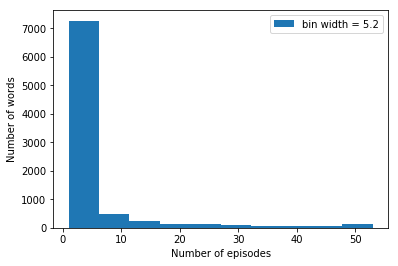

In [15]:
# YOUR CODE HERE
plt.hist(word_episode_count.values())
plt.xlabel('Number of episodes')
plt.ylabel('Number of words')
plt.legend(['bin width = 5.2'])
#raise NotImplementedError()

From the histogram above we can find that over $7000$ words are mentioned less or equal than $5$ episodes while only a few words appear in over $10$ episodes.

## Question 7 (Code Completition): Good Types

For the following question you will build an alphabetically sorted list of all words that appear in **more than one episode.** We shall refer to these words as *good types*. The strategy here is to eliminate very specific words that occur too rarely. The word *type* here refers to word types. Word types are unique words, i.e. *hello* and *goodbye* are two distinct word types. ["You say goodbye, and I say hello, hello, hello"](https://www.youtube.com/watch?v=rblYSKz_VnI&feature=youtu.be&t=16s) (warning -- link will play sound) is a sequence of 9 tokens (ignoring punctuation) and contains one *goodbye* type token, and three *hello* type tokens.

In the cell below fufill the specifications above and have the function: *produce an alphabetically sorted list of good types*. 

In [16]:
def output_good_types(input_word_counts):
    """Returns a list of good types in alphabeitcally sorted order
        Params: {input_word_counts: Dict}
        Returns: List
    """
    # YOUR CODE HERE
    word_list = []
    for word in input_word_counts.keys():
        if input_word_counts[word] > 1:
            word_list.append(word)
    return sorted(word_list)
    raise NotImplementedError()

In [17]:
good_types = output_good_types(word_episode_count)
n_good_types = len(good_types)

## Question 7b (Free Response): Good Types

In the cell below answer the following: *How many good_types there are? What are the first 10?*

In [18]:
# YOUR CODE HERE
print ('Number of good types: ', n_good_types)
print (good_types[0:9])
#raise NotImplementedError()

Number of good types:  4517
['a', 'aah', 'ability', 'able', 'about', 'absolute', 'absolutely', 'absurd', 'accent']


In [19]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that output_good_types returns the correct output"""
assert n_good_types > 4500 and n_good_types < 5000
assert good_types[0:5] == ['a','aah','ability','able','about']

From now on, the use of array data structures from `numpy` is highly recommended and required in some places. If you've never used numpy before, it will take some time to get used to. In general, numpy is a library that you can use to handle vector/matrix/tensor operations, including creation, modification, and compositions (add, sub, mul, etc.). For example, try running the following code:

In [20]:
A = np.array([[1,2,3], [4,6,2]]) 
B = np.array([[1,2],[5,3],[1,1]])
print(A) #A is a 2x3 matrix
print(B) #B is a 3x2 matrix
print(A.dot(B)) #A.dot(B) is a 2 by 2 matrix
print(np.sum(A, axis=0)) #np.sum(A, axis=0) sums along columns
print(np.sum(B, axis=1)) #np.sum(B, axis=1) sums along rows

[[1 2 3]
 [4 6 2]]
[[1 2]
 [5 3]
 [1 1]]
[[14 11]
 [36 28]]
[5 8 5]
[3 8 2]


You're welcome to find your own resources to learn more about numpy (there are lots of them) but one good introduction is [Justin Johnson's writeup](http://cs231n.github.io/python-numpy-tutorial/#numpy).

We will be using vectors and arrays with *n_good_types* columns, such that each good type corresponds to a column, in alphabetical order.

## Question 8 (Code Completion): Word Frequencies

What can you say about the most frequently words used? Would you expect to find the same ordering of frequent words in, say, the NY Times?

Note that we are talking about how many times a word appears over all episodes, rather than how many episodes a word appears in.

In the cell bellow, complete the function to *find the most frequently occurring words ("good types")*.

In [21]:
def create_ranked_good_types(tokenize_method,tokenize_transcript_method,input_transcripts,input_good_types):
    """Returns a list of good types in reverse sorted order in the form:
        [(word_1,word_count_1),
        ...
        (word_10,word_count_10)]
        Params: {tokenize_method: Function (a -> b),
                 tokenize_transcript_method: Function (a -> b,c),
                 input_transcripts: Tuple List,
                 input_good_types: List}
        Returns: List
    """
    # YOUR CODE HERE

    # BUILD TOKENIZED TRANSCRIPTS LIST
    dict_tokenized_transcripts = []
    for transcript in input_transcripts:
        dict_tokenized_transcripts.extend(tokenize_transcript_method(tokenize_method, transcript))
    
    # BUILD WORD EPISODE COUNT DICTIONARY
    good_type_appear_count = []
    for good_type in input_good_types:
        cnt = 0
        for word in dict_tokenized_transcripts:
            if word == good_type:
                    cnt += 1
        good_type_appear_count.append((good_type, cnt))
        
    return sorted(good_type_appear_count, key = lambda g_type: g_type[1], reverse = True)
    raise NotImplementedError()

In [22]:
ranked_counts = create_ranked_good_types(tokenize,tokenize_transcript,deduped_transcripts,good_types)

In [23]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_ranked_good_types returns the correct output"""
assert ranked_counts[0:2] == [('i',13972),('you',10920)]

## Question 8b (Free Response): Word Frequencies

Use the next cell to output the 10 most frequently occurring words ("good types") in the following format:

**Answer format:**

```
word_count_1 word_1
...
word_count_10 word_10 
```

In [24]:
# YOUR CODE HERE
for i in ranked_counts[0:10]:
    print('%-7s%-7s' % i)
#raise NotImplementedError()

i      13972  
you    10920  
to     8790   
s      6651   
the    6178   
and    5996   
a      5485   
it     5133   
that   4394   
t      3591   


## Characterizing characters' language

Moving on, we will only be considering a subset of characters, arguably the most important ones.

In [25]:
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']

n_speakers = len(good_speakers)

## Question 9 (Code Completion): Character Word Frequencies

In the cell below you will be asked to determine the *most frequently used words by each character*

This function will require you to return a numpy array of shape `n_speakers` by `n_good_types` such that the entry `(i,j)` indicates how often speaker i says word j.

In [26]:
def create_word_freq_array(
    tokenize_method,
    input_transcripts,
    input_speakers,
    input_good_types):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j.
    
    Params: {tokenize_method: Function (a -> b),
             input_transcripts: Tuple,
             input_speakers: List,
             input_good_types: List}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    word_freq_array = np.zeros((len(input_speakers), len(input_good_types)))
    
    for transcript in input_transcripts:
        for line in transcript[1]:
            if line['speaker'] in input_speakers:
                i = input_speakers.index(line['speaker'])
                tokenized_line = tokenize_method(line['text'])
                for word in tokenized_line:
                    if word in input_good_types:
                        j = input_good_types.index(word)
                        word_freq_array[i][j] += 1
    return word_freq_array
   
    raise NotImplementedError()

In [27]:
word_array = create_word_freq_array(tokenize,deduped_transcripts,good_speakers,good_types)

In [28]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(word_array[0]) > 26000.0
assert sum(word_array[:,3]) > 40 and sum(word_array[:,3]) < 50
assert type(word_array) == np.ndarray

## Question 9b (Free Response): Character Word Frequencies

In the cell below, output the *top 10 most frequent words used by each character* in the following format:

**Answer format**:

```
CHARACTER_NAME_A
word_1
word_2
...
word_10

CHARACTER_NAME_B
word_1
word_2
...
word_10

...
```

In [29]:
# YOUR CODE HERE
for i in range(len(good_speakers)):
    print (good_speakers[i])
    combine_good_type_freq = list(zip(good_types, word_array[i]))
    top_ten_words = sorted(combine_good_type_freq, key = lambda word: word[1], reverse = True)[0:10]
    for word in top_ten_words:
        print (word[0])
    print ()
#raise NotImplementedError()

BRUCE
i
you
the
s
to
it
a
and
that
this

JONATHAN
i
you
to
the
s
a
it
and
like
this

KHLOE
i
you
to
and
s
a
the
it
that
like

KIM
i
you
to
and
s
the
it
a
that
like

KOURTNEY
i
to
you
and
s
it
the
a
that
t

KRIS
i
you
to
s
the
a
and
it
that
t

ROBERT
i
to
you
s
and
a
the
just
it
that

SCOTT
i
you
to
s
the
a
it
that
and
t



## Question 10 (Code Completion): Specific Word Usage by Character

The above didn't help much in understanding each character's diction, because common words are used too commonly anyway. We want to give more weight to less frequent words, as they carry more information on the particularities of the characters.

A simple way to do this is to score the words according to the ratio between how often a given character said the word and how often any of the *good speakers* said it.  

This can be accomplished by dividing each columns in the `word_array` matrix by its sum.

Note: as some words might never be said by the key characters we are considering, apply *smoothing* by adding 1 to the sum of each column. Do this for each column, regardless of if smoothing is required for the math to work out.

In the cell below, complete the function to return a weighted numpy array of *specific* words used by each character?

In [30]:
def create_weighted_word_freq_array(input_word_array):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j weighted by the above ratio.
    
    Note: You must apply smoothing (by adding 1 to each column)
    
    Params: {input_word_array: Numpy Array}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    sum_by_column = 1 + np.sum(input_word_array, axis = 0)
    return input_word_array / sum_by_column
    raise NotImplementedError()

In [31]:
weighted_words = create_weighted_word_freq_array(word_array)

In [32]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(weighted_words[:,7]) > 0.7
assert type(weighted_words) == np.ndarray

## Question 10b (Free Response): Specific Word Usage by Character

Use the next cell to output the top 10 most *specific* words used by each character in the following format:

**Answer format**:

```
CHARACTER_NAME_A
score_1 word_1
score_2 word_2
...
score_10 word_10

CHARACTER_NAME_B
score_1 word_1
score_2 word_2
...
score_10 word_10

...
```

In [33]:
# YOUR CODE HERE
for i in range(len(good_speakers)):
    print (good_speakers[i])
    combine_good_type_freq = list(zip(good_types, weighted_words[i]))
    top_ten_words = sorted(combine_good_type_freq, key = lambda word: word[1], reverse = True)[0:10]
    for word in top_ten_words:
        print ('{0: <3.2f} {1:8s}'.format(word[1], word[0]))
    print ()
#raise NotImplementedError()

BRUCE
0.89 genetic 
0.88 hobby   
0.86 planners
0.83 brake   
0.83 carpool 
0.83 presentation
0.80 airplanes
0.80 fooling 
0.80 language
0.80 mcdonald

JONATHAN
0.91 erika   
0.89 katie   
0.89 pics    
0.80 awareness
0.76 simon   
0.75 beckham 
0.75 carmen  
0.75 command 
0.75 homely  
0.75 oats    

KHLOE
0.95 fur     
0.93 basic   
0.90 apparently
0.89 campaign
0.89 secure  
0.88 begins  
0.88 fulfilled
0.88 furs    
0.88 moral   
0.86 creepy  

KIM
0.91 amusing 
0.89 frizz   
0.89 song    
0.86 challenge
0.83 hotwire 
0.83 humiliating
0.83 punched 
0.81 airport 
0.80 advantage
0.80 bruised 

KOURTNEY
0.90 ho      
0.88 defensive
0.83 busted  
0.83 escalated
0.80 absurd  
0.80 cushion 
0.80 driveway
0.80 prevent 
0.80 sober   
0.80 theb    

KRIS
0.90 sweetie 
0.89 cristal 
0.88 cranky  
0.86 angeles 
0.86 chat    
0.86 kenneth 
0.86 los     
0.86 shops   
0.83 backup  
0.83 blew    

ROBERT
0.88 email   
0.86 anal    
0.86 truly   
0.83 adrian  
0.83 scream  
0.80 acceptable
0.80 o

## Question 10c (Free Response): Specific Word Usage by Character

Now we can start to see interesting differences between the characters.

Create a new Markdown cell bellow and use it to write a paragraph discussing the differences you find most striking.

From the data above we can see that the words frequently used by different major characters are so different. Bruce seems to have a strong interest in cars and planes. Jonathan mentioned a lot of names frequently so maybe he has many friends. Khloe uses the word 'fur' very often so she might be keen on luxury clothes. Both Kim and Koutney mentioned words related to violence and negative emotion quite a lot. Kris seems to be a nice person who loves chatting and shopping. Robert and Scott both talked a lot about sex.

This is the end of Assignment 1